In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import os
import re

In [4]:
dimp_dir = os.path.abspath('dimp_thor_no_reps')
OTB100 = 'C:\\Users\\alvis\\Documents\\Thesis\\pysot\\testing_dataset\\OTB100'

In [7]:
dimp_out = set(os.listdir(dimp_dir))
dimp_out = set(filter(lambda x: x.split('.')[1]=='txt' and not x.split('.')[0].endswith('_time'), dimp_out))
list(dimp_out)[:10]

['Panda.txt',
 'Sylvester.txt',
 'Girl.txt',
 'CarDark.txt',
 'Couple.txt',
 'Tiger2.txt',
 'Fish.txt',
 'MotorRolling.txt',
 'Board.txt',
 'Jumping.txt']

In [30]:
compare_dir = os.path.abspath('dimp_no_reps')

In [8]:
OCC = [
    'Basketball',
    'Biker',
    'Bolt',
    'Box',
    'CarScale',
    'ClifBar',
    'David',
    'DragonBaby',
    'Dudek',
    'Football ',
    'Freeman4 ',
    'Girl ',
    'Human3 ',
    'Human4 ',
    'Ironman ',
    'Jump ',
    'Liquor ',
    'Matrix ',
    'Panda ',
    'RedTeam ',
    'Skating1 ',
    'Skating2 ',
    'Soccer ',
    'Tiger ',
    'Walking ',
    'Walking2',
    'Woman',
    'Bird2 ',
    'Coke ',
    'Coupon ',
    'David3 ',
    'Doll ',
    'FaceOcc1 ',
    'FaceOcc2 ',
    'Girl2 ',
    'Human5',
    'Human7 ',
    'Jogging ',
    'KiteSurf ',
    'Lemming ',
    'Rubik',
    'Singer1 ',
    'Subway ',
    'Suv ',
    'Tiger1 ',
    'Trans',
]

In [9]:
Deformation = [
    'Basketball',
    'Bird1', 
    'Bird2', 
    'BlurBody', 
    'Bolt', 
    'Bolt2', 
    'Couple', 
    'Crossing', 
    'Crowds', 
    'Dancer', 
    'Dancer2', 
    'David', 
    'David3', 
    'Diving', 
    'Dog', 
    'Dudek', 
    'FleetFace', 
    'Girl2', 
    'Gym', 
    'Human3', 
    'Human4.2', 
    'Human5', 
    'Human6', 
    'Human7', 
    'Human8', 
    'Human9', 
    'Jogging.1', 
    'Jogging.2', 
    'Jump', 
    'Mhyang',
    'Panda', 
    'Singer2', 
    'Skater', 
    'Skater2', 
    'Skating1', 
    'Skating2.1', 
    'Skating2.2', 
    'Skiing', 
    'Subway', 
    'Tiger1', 
    'Tiger2', 
    'Trans', 
    'Walking', 
    'Woman'
]

In [10]:
metrics = {
    'OCC': OCC,
    'Deformation': Deformation
}

In [11]:
def bb_intersection_over_union(boxA, boxB):
    # print(boxA, boxB)
    # make sure all the values are intergers
    for i in range(0, 4):
        boxA[i] = int(boxA[i])
        boxB[i] = int(boxB[i])-1

    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou


In [12]:
def transform_gtbox(gt_bbox):
    gt_bbox = (gt_bbox[0], gt_bbox[1],
        gt_bbox[0]+gt_bbox[2], gt_bbox[1]+gt_bbox[3])
    return list(gt_bbox)

In [17]:
def smooth(v):
    lenght = 100
    div = int(v.shape[0]/lenght)
    v = v[:div * lenght]
    return np.mean(v.reshape(-1, div), axis =1)

In [14]:
def append_reverse_np(item, times):
    tmp = np.array([item if i % 2 == 0 else list(reversed(item)) for i in range(times)])
    return tmp.reshape(item.shape[0]*times, 4)

In [15]:
def convert_center_to_bbb(bboxes):
    p1x = int(bboxes[0] - 1)
    p1y = int(bboxes[1] - 1)
    p2x = int(bboxes[0] + bboxes[2] - 1)
    p2y = int(bboxes[1] + bboxes[3] - 1)
    # return (p1x, p1y), (p2x, p2y)
    return np.array([p1x, p1y, p2x, p2y])


In [18]:
metrics_result = {}
for k, v in metrics.items():
    metrics_result[k] = []

dimp_acc = []
for filename in dimp_out:
    print(filename)
    sample = re.search('(.*).txt', filename).group(1)

    try:
        try:
            gt_bbox = np.loadtxt(os.path.join(OTB100, sample, 'groundtruth_rect.txt'), delimiter=',')
        except:
            gt_bbox = np.loadtxt(os.path.join(OTB100, sample, 'groundtruth_rect.txt'), delimiter='\t')
    except:
        continue

    dimp_v = np.loadtxt(os.path.join(dimp_dir, filename), delimiter='\t')
    min_dim = dimp_v.shape[0]


    gt_bbox = append_reverse_np(gt_bbox, 40)
    gt_bbox = gt_bbox[:min_dim,:]

    da = []
    for d, gt in zip(dimp_v, gt_bbox):
        # gt = convert_center_to_bbb(gt)
        d = convert_center_to_bbb(d)
        da.append(bb_intersection_over_union(d, convert_center_to_bbb(gt)))

    da = smooth(np.asarray(da))
    dimp_acc.append(da)

    for k, v in metrics_result.items():
        if sample in metrics[k]:
            v.append(da)

Panda.txt
Sylvester.txt
Girl.txt
CarDark.txt
Couple.txt
Tiger2.txt
Fish.txt
MotorRolling.txt
Board.txt
Jumping.txt
RedTeam.txt
FaceOcc2.txt
Dancer.txt
Skating2_1.txt
Bolt2.txt
Bird2.txt


ValueError: cannot reshape array of size 0 into shape (0)

In [19]:
dimp_acc = np.array(dimp_acc)

for k, v in metrics_result.items():
    metrics_result[k] = np.array(v)

In [20]:
metrics_result['Deformation'].shape

(5, 100)

In [21]:
metrics_result['OCC'].shape


(0,)

# Plot of the total dataset


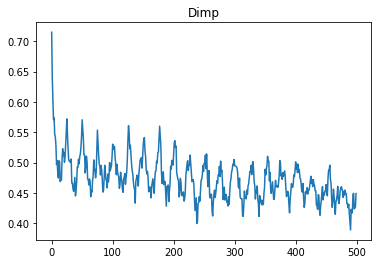

In [61]:
plt.plot(dimp_acc.mean(axis=0))
plt.title('Dimp')
plt.show()

# Plot of OCC subset

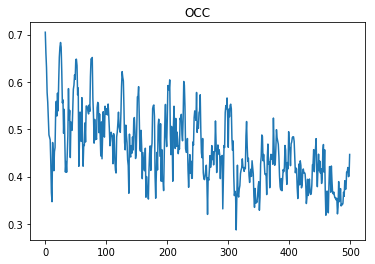

In [62]:
plt.title('OCC')
plt.plot(metrics_result['OCC'].mean(axis=0))
plt.show()

In [18]:
# Plot of deformation subset

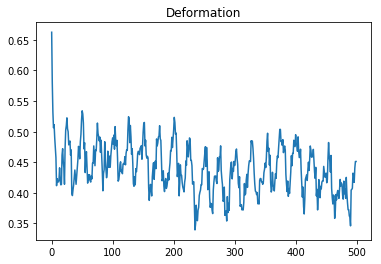

In [63]:
plt.title('Deformation')
plt.plot(metrics_result['Deformation'].mean(axis=0))
plt.show()

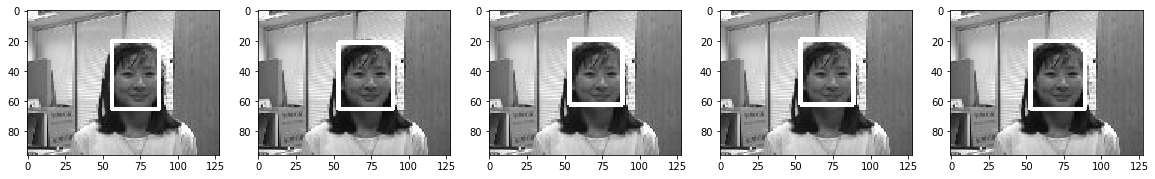

In [69]:
n_images = 500
siam_girl = np.loadtxt(os.path.join(dimp_dir, 'Girl.txt'), delimiter='\t')


girl_path = os.path.join(OTB100, 'Girl', 'img')
img = cv2.imread(os.path.join(girl_path, '0001.jpg'),0)


plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(2,5,i+1)
    siam_img = img.copy()
    r0 = convert_center_to_bbb(siam_girl[2*i*n_images,:]).astype(int)
    cv2.rectangle(siam_img, (r0[0],r0[1]),(r0[2],r0[3]),(255,0,0), 2)
    plt.imshow(siam_img, cmap='gray')

plt.show()

In [56]:

def show_acc_plot_compare(name, append =''):

    try:
        gt_bbox = np.loadtxt(os.path.join(OTB100, name, 'groundtruth_rect.txt'), delimiter=',')
    except:
        gt_bbox = np.loadtxt(os.path.join(OTB100, name, 'groundtruth_rect.txt'), delimiter='\t')

    dimp_v = np.loadtxt(os.path.join(dimp_dir, name + '.txt'), delimiter='\t')
    compare = np.loadtxt(os.path.join(compare_dir, name + append + '.txt'), delimiter='\t')
    min_dim = dimp_v.shape[0]


    gt_bbox = append_reverse_np(gt_bbox, 40)
    gt_bbox = gt_bbox[:min_dim,:]

    da, cb  = [], []
    for d,c,gt in zip(dimp_v, compare, gt_bbox):
        # gt = convert_center_to_bbb(gt)
        d = convert_center_to_bbb(d)
        c = convert_center_to_bbb(c)
        da.append(bb_intersection_over_union(c, convert_center_to_bbb(gt)))
        cb.append(bb_intersection_over_union(d, convert_center_to_bbb(gt)))

    # da = smooth(np.asarray(da))

    plt.title(f'Plot accuracy {name}')
    plt.plot(da)
    plt.plot(cb)
    plt.show()

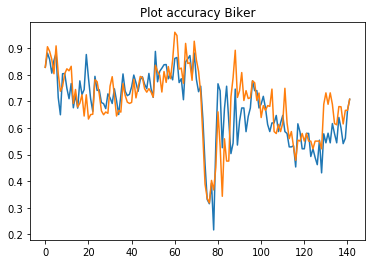

In [62]:
compare_dir = os.path.abspath('dimp_thor_avg')
show_acc_plot_compare('Biker',)

In [50]:

def show_acc_plot(name):

    try:
        gt_bbox = np.loadtxt(os.path.join(OTB100, name, 'groundtruth_rect.txt'), delimiter=',')
    except:
        gt_bbox = np.loadtxt(os.path.join(OTB100, name, 'groundtruth_rect.txt'), delimiter='\t')

    dimp_v = np.loadtxt(os.path.join(dimp_dir, name + '.txt'), delimiter='\t')
    min_dim = dimp_v.shape[0]


    # gt_bbox = append_reverse_np(gt_bbox, 40)
    # gt_bbox = gt_bbox[:min_dim,:]

    da = []
    print(len(dimp_v))
    for d, gt in zip(dimp_v, gt_bbox):
        # gt = convert_center_to_bbb(gt)
        d = convert_center_to_bbb(d)
        da.append(bb_intersection_over_union(d, convert_center_to_bbb(gt)))

    da = np.asarray(da)

    plt.title(f'Plot accuracy {name}')
    plt.plot(da)
    plt.show()

725


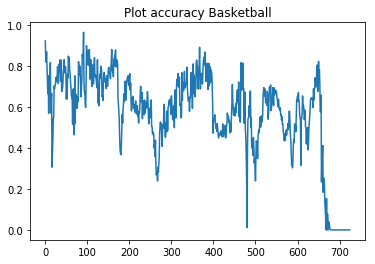

In [51]:
show_acc_plot('Basketball')

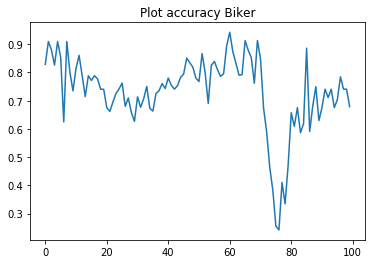

In [24]:
show_acc_plot('Biker')